In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# load libraries
import os
from typing import Dict, List, Tuple
import random
import json

import numpy as np
import pandas as pd

from pycocotools.coco import COCO

import skimage.io as io
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Load COCO

In [3]:
def get_img_ids_for_object_classes(coco: COCO, class_names: List[str], img_cnt_per_obj_type: int) -> List[int]:
    img_ids = []
    for obj_name in class_names:
        # filter images based on category
        filtered_cat_ids = coco.getCatIds(catNms=[obj_name])
        
        # find all image ids of the selected object
        ids = coco.getImgIds(catIds=filtered_cat_ids)
        
        # due to resource constraints, limit number of images per class
        if len(ids) > img_cnt_per_obj_type:
            ids = np.random.choice(ids, img_cnt_per_obj_type)
            img_ids.extend(ids.tolist())
        else:
            img_ids.extend(ids)

    # same objects may appear in multiple images
    img_ids = list(set(img_ids))
    
    return img_ids

In [4]:
# load config
def update_config(key, value):
    if check_config_exists():
        config = load_config()
    else:
        config = {}
    config[key] = value
    with open('./augmented_detr_config.json', 'w') as f:
        json.dump(config, f, indent=4)

def load_config():
    with open('./augmented_detr_config.json') as f:
        return json.load(f)

def check_config_exists():
    return os.path.exists('./augmented_detr_config.json')

In [5]:
data_dir='./data/coco/'
ann_file=f'{data_dir}/annotations/instances_train2017.json'

obj_types_to_be_selected = 5
img_cnt_for_training = 500
img_cnt_per_obj_type = img_cnt_for_training//obj_types_to_be_selected

# Initialize the COCO api
coco=COCO(ann_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
if not check_config_exists():
    # Load the categories in a variable
    all_cat_ids = coco.getCatIds()
    cats = coco.loadCats(all_cat_ids)

    def find_category_with_id(class_id: int, categories: List[Dict[str, str]]):
        for i in range(len(categories)):
            if categories[i]['id']==class_id:
                return categories[i]
        return None

    selected_objects = []
    for i in np.random.randint(0,90,obj_types_to_be_selected):
        category = find_category_with_id(i, cats)

        # check if it's a valid category and it is not already selected
        while category is None or category['name'] in selected_objects:
            i = np.random.randint(0,90)
            category = find_category_with_id(i, cats)

        # remember object name
        selected_objects.append(category['name'])
        print(f'selected id: {i}, super category: {category["supercategory"]}, name: {category["name"]}')

    print(f'Total number of images found: {len(get_img_ids_for_object_classes(coco,selected_objects,img_cnt_per_obj_type))}')

## Exploratory Data Analysis

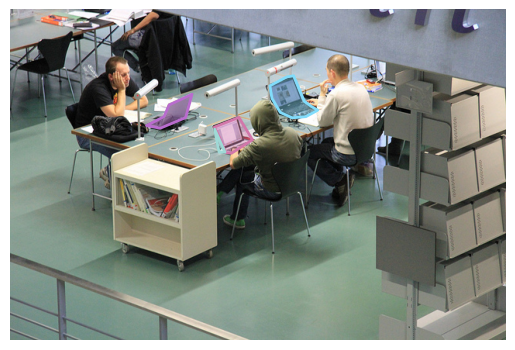

In [7]:
if not check_config_exists():
    # selected coco class names
    coco_class_names = ['sports ball', 'frisbee', 'broccoli', 'bench', 'handbag']
    update_config('coco_selected_object_names', coco_class_names)
else:
    config = load_config()
    coco_class_names = config['coco_selected_object_names']

img_ids = get_img_ids_for_object_classes(coco,coco_class_names,img_cnt_per_obj_type)

# load and display a random image
img_id = img_ids[0]
img = coco.loadImgs(img_id)[0]
I = io.imread(f'{data_dir}/train2017/{img["file_name"]}')/255.0

plt.axis('off')
plt.imshow(I)

annIds = coco.getAnnIds(imgIds=img_id,iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

plt.show()

In [8]:
# check total images
len(img_ids)

384

Total 960 images are found for object types 'sports ball', 'pizza', 'toaster', 'frisbee', 'clock', 'broccoli', 'apple', 'bench', 'handbag', 'giraffe' with a maximum of 100 per object type

Apply segmentation mask to loaded image

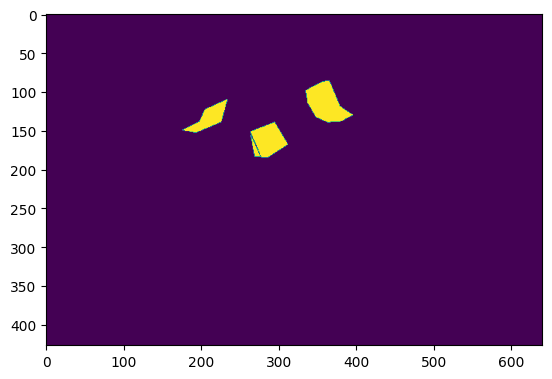

In [9]:
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)
plt.show()

Find objects that are in selected class names

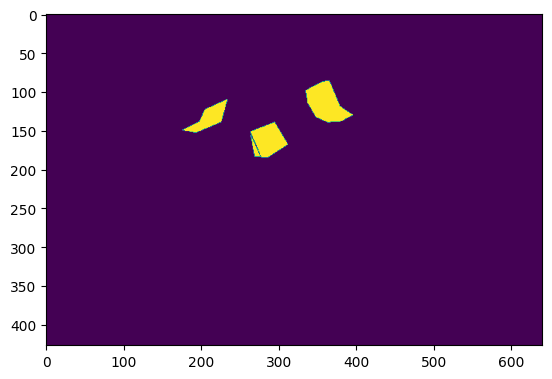

In [10]:
all_cat_ids = coco.getCatIds()
cats = coco.loadCats(all_cat_ids)
def get_class_name(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = get_class_name(anns[i]['category_id'], cats)
    if className in coco_class_names:
        pixel_value = coco_class_names.index(className)+1
        mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)
plt.show()

Load selected images

In [11]:
def load_img_obj_from_ids(img_ids: List[int], coco: COCO):
    # load selected images
    images = coco.loadImgs(img_ids)
        
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
                
    random.shuffle(unique_images)
    
    return unique_images

unique_images = load_img_obj_from_ids(img_ids, coco)

## Subset COCO to only selected images to save computational resources

In [ ]:
import shutil

def subset_data(mode: str):
    if not os.path.exists(f'{data_dir}/{mode}2017'):
        os.mkdir(f'{data_dir}/{mode}2017')
    else:
        return # already present
    
    ann_file=f'{data_dir}/annotations/instances_{mode}2017.json'
    coco=COCO(ann_file)
    
    img_ids = get_img_ids_for_object_classes(coco,coco_class_names,img_cnt_per_obj_type)
    update_config(f'{mode}_img_ids', img_ids)
    
    imgs = load_img_obj_from_ids(img_ids, coco)
    for img in imgs:
        shutil.copyfile(f'{data_dir}/images/{mode}/{img["file_name"]}', f'{data_dir}/{mode}2017/{img["file_name"]}')

subset_data('val')
subset_data('train')

In [ ]:
def subset_ann(mode: str):
    ann_file=f'{data_dir}/annotations/instances_{mode}2017.json'
    with open(ann_file) as f:
        d = json.load(f)
        
    img_ids = load_config()[f'{mode}_img_ids']

    selected_objs = []
    for img in d['images']:
        if img['id'] in img_ids:
            selected_objs.append(img)

    d['images'] = selected_objs

    selected_objs = []
    coco=COCO(ann_file)
    id2label = {k: v['name'] for k,v in coco.cats.items() if v['name'] in coco_class_names}
    for i in img_ids:
        for a in coco.loadAnns(coco.getAnnIds(i)):
            if a['category_id'] in id2label:
                selected_objs.append(a)


    # for a in d['annotations']:
    #     if a['image_id'] in img_ids:
    #         selected_objs.append(a)

    d['annotations'] = selected_objs

    selected_objs = []
    filtered_cat_ids = []
    for obj_name in coco_class_names:
        filtered_cat_ids.append(coco.getCatIds(catNms=[obj_name])[0])

    filtered_cat_ids = list(set(filtered_cat_ids))
    for c in d['categories']:
        if c['id'] in filtered_cat_ids:
            selected_objs.append(c)

    d['categories'] = selected_objs
    
    with open(f'{data_dir}/annotations/instances_{mode}2017.json', 'w') as f:
        json.dump(d, f)


# subset_ann('val')
# subset_ann('train')

## Data Augmentations

In [12]:
%cd detr

c:\Code\augmented_detr\src\notebooks\detr


In [13]:
from datasets.coco import CocoDetection

data_dir = '../data/coco/'
train_dataset = CocoDetection(f'{data_dir}/train2017', f'{data_dir}/annotations/instances_train2017.json', None, True)
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
id2label


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{14: 'parking meter', 31: 'handbag', 36: 'snowboard', 73: 'laptop', 86: 'vase'}

In [14]:
%cd ..
data_dir = './data/coco/'


c:\Code\augmented_detr\src\notebooks


In [15]:
# https://albumentations.ai/docs/examples/example_bboxes/

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(img)



### Color space

#### Grayscale

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


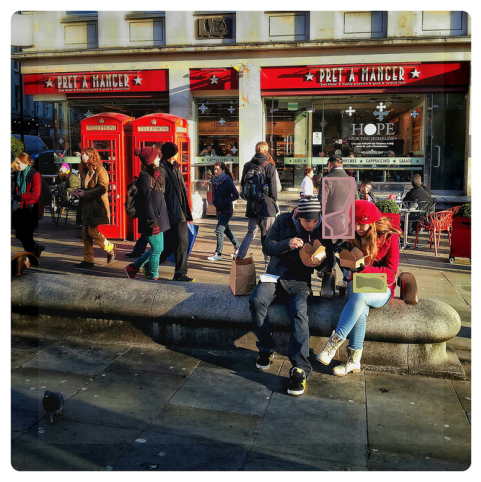

In [16]:
from PIL import Image

def get_img_and_anns(mode: str):
    img_ids = load_config()[f'{mode}_img_ids']
    coco = COCO(f'{data_dir}/annotations/instances_{mode}2017.json')
    img_id = np.random.choice(img_ids)
    img_obj = coco.loadImgs([img_id])[0]
    img = io.imread(f'{data_dir}/{mode}2017/{img_obj["file_name"]}') #Image.open(f'{data_dir}/{mode}2017/{img_obj["file_name"]}')

    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(annIds)

    return img, anns, img_obj


def get_bboxes_and_cats_from_anns(anns):
    return [ann['bbox'] for ann in anns], [ann['category_id'] for ann in anns]


img, anns, img_obj = get_img_and_anns('train')
bboxes, cats = get_bboxes_and_cats_from_anns(anns)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(img)
coco.showAnns(anns, draw_bbox=True)


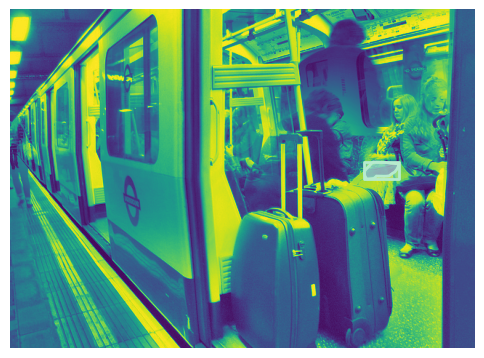

In [15]:
from skimage import color
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(color.rgb2gray(img))
coco.showAnns(anns, draw_bbox=True)

Converting to grayscale has no effect on the bounding box

In [ ]:
img.shape, color.rgb2gray(img).shape


Converting to grayscale removes the third dimension, reducing computational complexity

### Geometric

In [ ]:
!pip install albumentations


In [ ]:
import albumentations as A
import cv2


#### Flipping

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=1.0),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transformed = transform(image=img, bboxes=bboxes, category_ids=cats)

visualize(transformed['image'], transformed['bboxes'],
          transformed['category_ids'], id2label)


#### Translation

In [ ]:
transform = A.Compose([
    A.Affine(translate_percent=np.random.random_sample(),p=1.0),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transformed = transform(image=img, bboxes=bboxes, category_ids=cats)

visualize(transformed['image'], transformed['bboxes'],
          transformed['category_ids'], id2label)


#### Rotation

In [ ]:
transform = A.Compose([
    A.Affine(rotate=np.random.randint(1,359), p=1.0),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transformed = transform(image=img, bboxes=bboxes, category_ids=cats)

visualize(transformed['image'], transformed['bboxes'],
          transformed['category_ids'], id2label)


#### Cropping

In [ ]:
transform = A.Compose([
    A.RandomSizedBBoxSafeCrop(350, 350),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transformed = transform(image=img, bboxes=bboxes, category_ids=cats)

visualize(transformed['image'], transformed['bboxes'],
          transformed['category_ids'], id2label)

### Copy Paste

In [ ]:
%cd detr


In [ ]:
def get_mask(img, anns):
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(len(anns)):
        mask = np.maximum(coco.annToMask(anns[i]), mask)

    return mask

In [ ]:
img, anns, img_obj = get_img_and_anns('train')
bboxes, cats = get_bboxes_and_cats_from_anns(anns)
mask = get_mask(img, anns)

In [ ]:
def extract_objects(img, anns, coco):
    outputs = []
    for ann in anns:
        mask = coco.annToMask(ann)
        img_cropped = img * mask[:,:,np.newaxis]
        rows, cols = np.where(mask)
        top_row, bottom_row = rows.min(), rows.max()
        left_col, right_col = cols.min(), cols.max()
        
        if top_row == bottom_row:
            bottom_row += 1
        
        if left_col == right_col:
            right_col += 1
        
        outputs.append((img_cropped[top_row:bottom_row, left_col:right_col], ann))
    return outputs

coco = COCO(f'{data_dir}/annotations/instances_train2017.json')

In [ ]:
num_of_copies = 2
objects = extract_objects(img, anns, coco)
img_obj, ann_obj = objects[0]
mask_obj = coco.annToMask(ann_obj)

pil_img = Image.fromarray(img)

for i in range(num_of_copies):
    # check if x,y overlap with other objects
    mask =np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(coco.annToMask(ann), mask)
        
    has_overlap = True
    while has_overlap:
        # generate random positions
        x, y = np.random.randint(
            0, img.shape[1]), np.random.randint(0, img.shape[0])

        mask_bg_cropped = mask[y:y+img_obj.shape[0], x:x+img_obj.shape[1]]
        mask_obj_cropped = cv2.resize(
            mask_obj, (mask_bg_cropped.shape[1], mask_bg_cropped.shape[0]))

        has_overlap = np.bitwise_and(mask_bg_cropped, mask_obj_cropped).any()
        
        has_overlap = has_overlap or (
            (y+img_obj.shape[0]) > img.shape[0]) or ((x+img_obj.shape[1]) > img.shape[1])
    
    # blend image
    alpha = np.ones(img_obj.shape[:2], dtype=np.float32) * 0.7
    alpha = np.dstack((alpha, alpha, alpha))
    img_obj_alpha = np.concatenate((img_obj, alpha), axis=2)
    
    # blend with object
    img[y:y+img_obj.shape[0], x:x+img_obj.shape[1],
        :] = img[y:y+img_obj.shape[0], x:x+img_obj.shape[1], :] * (1-alpha) + img_obj_alpha[:,:,:3] * alpha
    
    # img[y:y+img_obj.shape[0], x:x+img_obj.shape[1],:] = img_obj

plt.imshow(img)

### Random Erasing

In [ ]:
from torchvision.transforms import RandomErasing
import torchvision.transforms as transforms

In [ ]:
# @inproceedings{zhong2020random,
# title={Random Erasing Data Augmentation},
# author={Zhong, Zhun and Zheng, Liang and Kang, Guoliang and Li, Shaozi and Yang, Yi},
# booktitle={Proceedings of the AAAI Conference on Artificial Intelligence (AAAI)},
# year={2020}
# }

In [ ]:
transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.RandomErasing(p=1, value='random'),
    transforms.ToPILImage()
])

pil_img = Image.fromarray(img)
transformed = np.array(transform(pil_img))

visualize(transformed, bboxes,
          cats, id2label)


### Noise Injection

In [ ]:
transform = A.Compose([
    A.GaussNoise(p=1),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

transformed = transform(image=img, bboxes=bboxes, category_ids=cats)

visualize(transformed['image'], transformed['bboxes'],
          transformed['category_ids'], id2label)


### Pretraining

In [ ]:
import shutil

# save cropped objects
def crop_and_save_objects():
    if not os.path.exists('./data/coco/objects'):
        os.mkdir('./data/coco/objects')
    else:
        shutil.rmtree('./data/coco/objects')

    coco = COCO(f'{data_dir}/annotations/instances_train2017.json')
    img_ids = load_config()['train_img_ids']
    img_objs = coco.loadImgs(img_ids)
    for img_obj in img_objs:
        img = io.imread(f'{data_dir}/train2017/{img_obj["file_name"]}')
        annIds = coco.getAnnIds(imgIds=img_obj['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)

        objects = extract_objects(img, anns, coco)
        
        for o in objects:
            obj, ann = o
            cv2.imwrite(
                f'./data/coco/objects/{img_obj["id"]}_{id2label[ann["category_id"]]}.jpg', obj)


crop_and_save_objects()


## DETR Fork

In [17]:
# !rm -rf detr
!git clone https://github.com/ahmfrz/detr.git
%cd detr

c:\Code\augmented_detr\src\notebooks\detr


fatal: destination path 'detr' already exists and is not an empty directory.


In [18]:
import dataclasses

@dataclasses.dataclass
class Config():
    epochs: int=200
    obj_types_to_be_selected: int=5
    lr: float=1e-4
    weight_decay: float=1e-4
    output_dir: str="..\output"
    backbone: str="resnet50"
    batch_size: int=9
    resume: str="..\detr-r50_no-class-head.pth"
    has_custom_detection_class: bool=False
    transform_type: str = 'None'
    coco_path="..\data\coco"


In [19]:
from detr.main import main, get_args_parser
import argparse
from pathlib import Path

def train_detr(config: Config):
    parser = argparse.ArgumentParser(
        'DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args([
        '--num_queries', str(config.obj_types_to_be_selected),
        '--coco_path', config.coco_path,
        '--lr', str(config.lr),
        '--weight_decay', str(config.weight_decay),
        '--output_dir', config.output_dir,
        '--backbone', config.backbone,
        '--batch_size', str(config.batch_size),
        '--resume', "..\detr-r50_no-class-head.pth",
        '--epochs', str(config.epochs),
        '--has_custom_detection_class', config.has_custom_detection_class,
        '--transform_type', config.transform_type
    ])

    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)

    main(args)


In [19]:
import torch

# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
    map_location='cpu',
    check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
del checkpoint["model"]["query_embed.weight"]

# Save
torch.save(checkpoint,
           '../detr-r50_no-class-head.pth')


In [ ]:
os.getcwd()

## Base DETR

In [ ]:
train_detr(Config(output_dir='../output/base'))

In [ ]:
from util.plot_utils import plot_logs
from pathlib import Path

log_directory = [Path('../output/base')]

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

In [ ]:

fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

Load the fine-tuned model

In [ ]:
import torch
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=obj_types_to_be_selected)

checkpoint = torch.load('../output/base/checkpoint.pth',
                        map_location='cpu')

del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
del checkpoint["model"]["query_embed.weight"]

model.load_state_dict(checkpoint['model'],
                      strict=False)

# model.eval()

Boilerplate functions to display fine-tuned results

In [ ]:
# colors for visualization
import torchvision.transforms as T
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled


In [ ]:


def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16, 10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{coco_class_names[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


In [ ]:
def run_workflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.5, 0.4]:

    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                               threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep,
                           bboxes_scaled)


With a training image


In [ ]:
%cd ..

In [ ]:
import json
coco_class_names = load_config()['coco_selected_object_names']


In [ ]:
from PIL import Image

data_dir = './data/coco/'
train_img_ids = load_config()['train_img_ids']
coco = COCO(f'{data_dir}/annotations/instances_train2017.json')
img_obj = coco.loadImgs(train_img_ids[:5])[4]
img_name = f'{data_dir}/train2017/{img_obj["file_name"]}'
im = Image.open(img_name)

run_workflow(im,
            model)


With a validation image

In [ ]:
from PIL import Image

val_img_ids = load_config()['val_img_ids']
coco = COCO(f'{data_dir}/annotations/instances_val2017.json')
img_obj = coco.loadImgs(val_img_ids[:5])[2]
img_name = f'{data_dir}/val2017/{img_obj["file_name"]}'
im = Image.open(img_name)

run_workflow(im, model)


In [ ]:
%cd detr/

## DETR with geometric augmentations

In [ ]:
train_detr(Config(output_dir='../output/geometric', 
                  has_custom_detection_class='True',
                  transform_type='geometric'))

## DETR with Copy Paste augmentation

In [20]:
train_detr(Config(output_dir='../output/copypaste', 
                  has_custom_detection_class='True',
                  transform_type='copypaste',
                  batch_size=5))

Not using distributed mode
git:
  sha: f3b4fad8184edea299db4fb685bdb4d68cd366df, status: clean, branch: main

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=5, weight_decay=0.0001, epochs=200, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=5, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='..\\data\\coco', coco_panoptic_path=None, remove_difficult=False, output_dir='../output/copypaste', device='cuda', seed=42, resume='..\\detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', has_custom_detection_class='True', transform_type='copypaste', distributed=False)


c:\Code\augmented_detr\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Code\augmented_detr\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of params: 41278048
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Start training


c:\Code\augmented_detr\src\notebooks\detr\models\position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


Epoch: [0]  [ 0/98]  eta: 0:11:35  lr: 0.000100  class_error: 100.00  loss: 14614.6807 (14614.6807)  loss_ce: 4.0461 (4.0461)  loss_bbox: 2428.3691 (2428.3691)  loss_giou: 3.4390 (3.4390)  loss_ce_0: 3.9144 (3.9144)  loss_bbox_0: 2428.3059 (2428.3059)  loss_giou_0: 3.4397 (3.4397)  loss_ce_1: 3.9080 (3.9080)  loss_bbox_1: 2428.3506 (2428.3506)  loss_giou_1: 3.4398 (3.4398)  loss_ce_2: 4.0351 (4.0351)  loss_bbox_2: 2428.3638 (2428.3638)  loss_giou_2: 3.4397 (3.4397)  loss_ce_3: 3.9985 (3.9985)  loss_bbox_3: 2428.3647 (2428.3647)  loss_giou_3: 3.4390 (3.4390)  loss_ce_4: 4.0140 (4.0140)  loss_bbox_4: 2428.3743 (2428.3743)  loss_giou_4: 3.4390 (3.4390)  loss_ce_unscaled: 4.0461 (4.0461)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 485.6738 (485.6738)  loss_giou_unscaled: 1.7195 (1.7195)  cardinality_error_unscaled: 1.2000 (1.2000)  loss_ce_0_unscaled: 3.9144 (3.9144)  loss_bbox_0_unscaled: 485.6612 (485.6612)  loss_giou_0_unscaled: 1.7198 (1.7198)  cardinality_error_0_u

KeyboardInterrupt: 

## DETR with Random Erasing augmentation

In [ ]:
train_detr(Config(output_dir='../output/randomerasing', 
                  has_custom_detection_class='True',
                  transform_type='randomerasing'))

## DETR with Noise Injection augmentation

In [ ]:
train_detr(Config(output_dir='../output/noise', 
                  has_custom_detection_class='True',
                  transform_type='noise'))

## DETR with Geometric+Noise Injection augmentation

In [27]:
train_detr(Config(output_dir='../output/geometric+noise', 
                  has_custom_detection_class='True',
                  transform_type='geometric+noise'))

Not using distributed mode
git:
  sha: f3b4fad8184edea299db4fb685bdb4d68cd366df, status: has uncommited changes, branch: main

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=9, weight_decay=0.0001, epochs=200, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=5, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='..\\data\\coco', coco_panoptic_path=None, remove_difficult=False, output_dir='../output/geometric+noise', device='cuda', seed=42, resume='..\\detr-r50_no-class-head.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', has_custom_detection_class='True', transform_type='geometric+noise', distributed=False)
number of params: